In [ ]:
from core.quantum_error_correction_code import SurfaceCode
from core.neural_network import CNNDual, load_params

from core.environment import EnvironmentCNN

import jax.numpy as jnp
from jax import random
from time import time

key = random.key(32)

In [2]:
settings, model_params = load_params("data/general_distance3_decoder.json")
print(settings.keys())

CODE_DISTANCE = settings["CODE_DISTANCE"]
print(f"{CODE_DISTANCE = }")

DEFORMATION_OPTIONS = settings["DEFORMATION_OPTIONS"]
print(f"{DEFORMATION_OPTIONS = }")

ERROR_PROBS = settings["ERROR_PROBS"]
print(f"{ERROR_PROBS = }")

CONV_LAYERS_INPUT_1 = [tuple(int(v) for v in elm) for elm in settings["CONV_LAYERS_INPUT_1"]]
print(f"{CONV_LAYERS_INPUT_1 = }")

CONV_LAYERS_INPUT_2 = [tuple(int(v) for v in elm) for elm in settings["CONV_LAYERS_INPUT_2"]]
print(f"{CONV_LAYERS_INPUT_2 = }")

CONV_LAYERS_STAGE_2 = [tuple(int(v) for v in elm) for elm in settings["CONV_LAYERS_STAGE_2"]]
print(f"{CONV_LAYERS_STAGE_2 = }")

FC_LAYERS = settings["FC_LAYERS"].tolist()
print(f"{FC_LAYERS = }")

CODE_DEFORMATION = jnp.zeros(CODE_DISTANCE**2, dtype=jnp.int32)

dict_keys(['CODE_DISTANCE', 'DEFORMATION_OPTIONS', 'ERROR_PROBS', 'CONV_LAYERS_INPUT_1', 'CONV_LAYERS_INPUT_2', 'CONV_LAYERS_STAGE_2', 'FC_LAYERS'])
CODE_DISTANCE = 3
DEFORMATION_OPTIONS = Array([0, 1, 2, 3, 4, 5], dtype=int32)
ERROR_PROBS = Array([9.98004e-06, 9.98004e-06, 9.98004e-03], dtype=float32)
CONV_LAYERS_INPUT_1 = [(8, 2, 1, 0)]
CONV_LAYERS_INPUT_2 = [(8, 1, 1, 0)]
CONV_LAYERS_STAGE_2 = [(8, 2, 1, 0)]
FC_LAYERS = [50, 2]


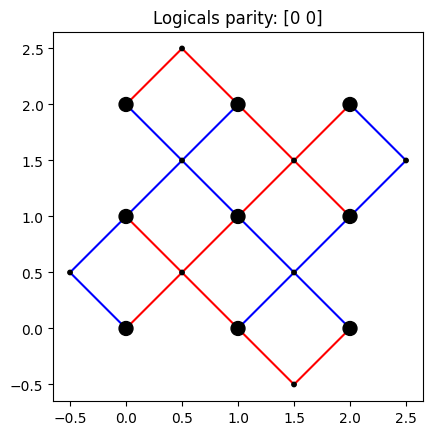

In [3]:
code = SurfaceCode(CODE_DISTANCE)
parity_info = code.deformation_parity_info(CODE_DEFORMATION)
code.show(parity_info)

In [4]:
model = CNNDual(
    input_shape_1 = (1, CODE_DISTANCE+1, CODE_DISTANCE+1),
    input_shape_2 = (6, CODE_DISTANCE, CODE_DISTANCE),
    conv_layers_input_1 = CONV_LAYERS_INPUT_1,
    conv_layers_input_2 = CONV_LAYERS_INPUT_2,
    conv_layers_stage_2 = CONV_LAYERS_STAGE_2,
    fc_layers = FC_LAYERS
)
model.layer_sizes

{'CNN_input_1': [(1, 4, 4), (8, 3, 3)],
 'CNN_input_2': [(6, 3, 3), (8, 3, 3)],
 'CNN_stage_2': [(8, 3, 3), (8, 2, 2)],
 'MLP_stage_3': [32, 50, 2]}

In [5]:
env = EnvironmentCNN(
    model=model,
    model_params=model_params,
    noise_model=ERROR_PROBS,
    code=code,
    shots=1_000_000
)

In [6]:
state, score, key = env.reset(key)

In [7]:
time_limit = 10
sample_count = 0
t0 = time()
while time() - t0 < time_limit:
    state, score, key = env.reset(key)
    sample_count = sample_count + 1
print(f"Average execution time = {(time()-t0)/sample_count/env.shots*1E6:.3f}s per 1M shots ({sample_count} samples)")

Average execution time = 0.457s per 1M shots (22 samples)


In [8]:
scores = []
for i in range(100):
    state, score, key = env.reset(key)
    scores.append(score)

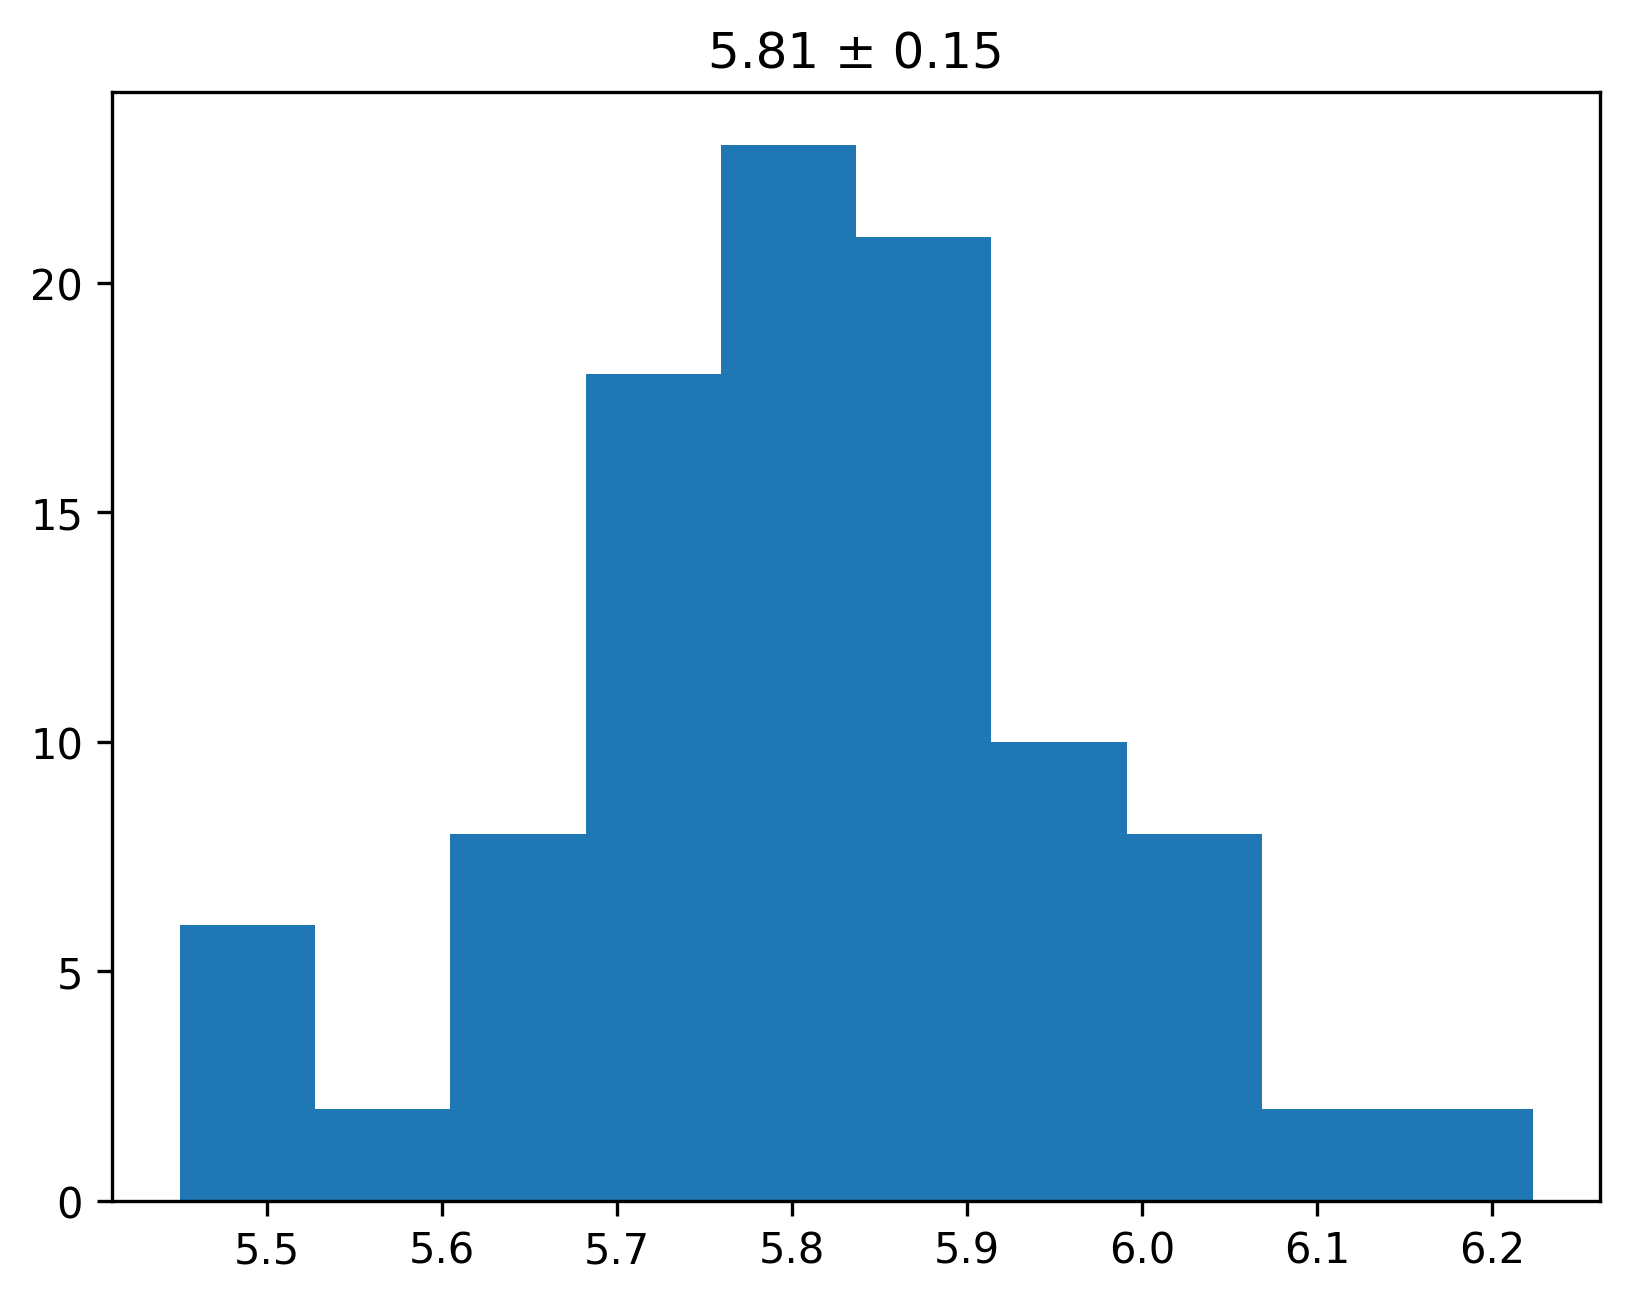

In [9]:
import matplotlib.pyplot as plt

x = jnp.array(scores)

plt.figure(dpi=300)
plt.title(f"{x.mean():.2f} ± {x.std():.2f}")
plt.hist(x)
plt.show()